OULAD Project 1 Predict Student Academic Performance Pass Fail.
This notebook focuses on data understanding, preparation, and a simple model to predict pass or fail. The default goal is early warning so assessment derived features are excluded from modeling. If you want end of course prediction, change the prediction goal in the modeling cell.


Section 1 Setup and configuration.


In [1]:
# Core
import os
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Feature selection
from sklearn.feature_selection import RFE

# Bonus models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 200)
np.random.seed(42)


/tmp/pydeps/joblib/_multiprocessing_helpers.py:44: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn("%s.  joblib will operate in serial mode" % (e,))


In [2]:
# CHANGE THIS to your local folder containing the 7 OULAD CSV files
DEFAULT_DATA_DIR = os.path.join('.', 'data', 'oulad')

required_files = [
    'assessments.csv','courses.csv','studentAssessment.csv','studentInfo.csv',
    'studentRegistration.csv','studentVle.csv','vle.csv'
]

# Resolve DATA_DIR from common locations
candidate_dirs = [DEFAULT_DATA_DIR, '.']
resolved = None
for d in candidate_dirs:
    if all(os.path.exists(os.path.join(d, f)) for f in required_files):
        resolved = d
        break

if resolved is None:
    missing = [f for f in required_files if not os.path.exists(os.path.join(DEFAULT_DATA_DIR, f))]
    print('Missing files in DEFAULT_DATA_DIR:', missing)
    print('DEFAULT_DATA_DIR currently set to:', os.path.abspath(DEFAULT_DATA_DIR))
    print('Also checked:', os.path.abspath('.'))
else:
    DATA_DIR = resolved
    print('Using DATA_DIR:', os.path.abspath(DATA_DIR))


Using DATA_DIR: /mnt/d/Project/DBM_FINAL


Section 2 Data loading and overview. The seven OULAD csv files are loaded and basic shapes are shown.


In [3]:
def read_csv(name, usecols=None, dtype=None):
    path = os.path.join(DATA_DIR, name)
    return pd.read_csv(path, usecols=usecols, dtype=dtype, low_memory=False)

# Read small/medium tables fully
assessments = read_csv('assessments.csv')
courses = read_csv('courses.csv')
student_info = read_csv('studentInfo.csv')
student_reg = read_csv('studentRegistration.csv')
student_assess = read_csv('studentAssessment.csv')
vle = read_csv('vle.csv')

# Read the large clickstream table with only needed columns + smaller dtypes
student_vle = read_csv(
    'studentVle.csv',
    usecols=['code_module','code_presentation','id_student','id_site','date','sum_click'],
    dtype={
        'code_module':'category','code_presentation':'category',
        'id_student':'int32','id_site':'int32',
        'date':'int16','sum_click':'int32'
    }
)

# Quick overview (rows, cols)
overview = pd.DataFrame({
    'table': ['assessments','courses','studentInfo','studentRegistration','studentAssessment','vle','studentVle'],
    'rows': [len(assessments),len(courses),len(student_info),len(student_reg),len(student_assess),len(vle),len(student_vle)],
    'cols': [assessments.shape[1],courses.shape[1],student_info.shape[1],student_reg.shape[1],student_assess.shape[1],vle.shape[1],student_vle.shape[1]]
})
overview


,table,rows,cols
0,assessments,206,6
1,courses,22,3
2,studentInfo,32593,12
3,studentRegistration,32593,5
4,studentAssessment,173912,5
5,vle,6364,6
6,studentVle,10655280,6


Section 3 Data cleaning and justification. We remove known invalid assessment ids, drop non numeric scores, deduplicate click records, and keep missing values for imputation. These steps reduce noise and prevent incorrect aggregates.


In [4]:
# --- 3.1 assessments: drop known invalid IDs (common in OULAD copies)
# If IDs are missing in your version, this line is harmless.
invalid_ids = {40087, 40088}
assessments = assessments[~assessments['id_assessment'].isin(invalid_ids)].copy()

# Ensure numeric types where needed
assessments['weight'] = pd.to_numeric(assessments['weight'], errors='coerce')
assessments['date'] = pd.to_numeric(assessments['date'], errors='coerce')

# --- 3.2 studentAssessment: clean score/date
student_assess['score'] = student_assess['score'].replace(['?', '', ' '], np.nan)
student_assess['score'] = pd.to_numeric(student_assess['score'], errors='coerce')
student_assess['date_submitted'] = pd.to_numeric(student_assess['date_submitted'], errors='coerce')
student_assess['is_banked'] = pd.to_numeric(student_assess['is_banked'], errors='coerce').fillna(0).astype(int)

before = len(student_assess)
student_assess = student_assess.dropna(subset=['score']).copy()
print('Dropped rows with missing/non-numeric score:', before - len(student_assess))

# --- 3.3 studentInfo: clean imd_band and normalize age label
student_info['imd_band'] = student_info['imd_band'].replace('?', np.nan)
student_info['age_band'] = student_info['age_band'].replace({'55<=': '>=55'})

# --- 3.4 studentVle: drop duplicates to avoid inflated click counts
before = len(student_vle)
student_vle = student_vle.drop_duplicates().copy()
print('Dropped duplicate rows in studentVle:', before - len(student_vle))

# Sanity
print('studentVle rows after dedup:', len(student_vle))


Dropped rows with missing/non-numeric score: 173


Dropped duplicate rows in studentVle: 787170
studentVle rows after dedup: 9868110


Section 4 Feature engineering and transformation. We create the target pass fail, aggregate VLE engagement, compute assessment summaries, add registration flags, and apply log transforms and outlier capping.


In [5]:
# --- 4.1 Create target (binary) from final_result
student_info['final_result_upd'] = student_info['final_result'].replace({
    'Distinction': 'Pass',
    'Withdrawn': 'Fail'
})
student_info = student_info[student_info['final_result_upd'].isin(['Pass','Fail'])].copy()
student_info['final_result_upd_numeric'] = (student_info['final_result_upd'] == 'Pass').astype(int)

# --- 4.2 VLE features (aggregate to student-module-presentation grain)
# total clicks + active days
vle_agg = (
    student_vle
    .groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
    .agg(
        total_sum_click=('sum_click','sum'),
        active_days=('date','nunique')
    )
)

# early engagement (<= 14 days)
early = student_vle[student_vle['date'] <= 14]
early_agg = (
    early.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
         .agg(early_sum_click=('sum_click','sum'), early_active_days=('date','nunique'))
)

vle_features = vle_agg.merge(early_agg, on=['id_student','code_module','code_presentation'], how='left')
vle_features[['early_sum_click','early_active_days']] = vle_features[['early_sum_click','early_active_days']].fillna(0)

vle_features['early_click_ratio'] = vle_features['early_sum_click'] / vle_features['total_sum_click'].replace(0, np.nan)
vle_features['early_click_ratio'] = vle_features['early_click_ratio'].fillna(0)

# log transforms to reduce skew
vle_features['log1p_total_sum_click'] = np.log1p(vle_features['total_sum_click'])
vle_features['log1p_early_sum_click'] = np.log1p(vle_features['early_sum_click'])


In [6]:
# --- 4.3 Assessment features: weighted score and overall grade
# Join studentAssessment with assessments metadata
sa = student_assess.merge(
    assessments[['id_assessment','code_module','code_presentation','assessment_type','weight','date']],
    on='id_assessment', how='left'
)

# Weighted score rule: if is_banked==1 -> 0 else score * weight
sa['weighted_score'] = np.where(sa['is_banked'] == 1, 0, sa['score'] * (sa['weight'] / 100.0))

# Lateness (optional feature)
sa['lateness_days'] = sa['date_submitted'] - sa['date']

assess_agg = (
    sa.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
      .agg(
          exam_weighted=('weighted_score', lambda x: x[sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          non_exam_weighted=('weighted_score', lambda x: x[~sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          mean_score=('score','mean'),
          late_submissions=('lateness_days', lambda s: (s>0).sum())
      )
)

# overall_grade rule: average if both exist, else use the one available
assess_agg['has_exam'] = (assess_agg['exam_weighted'] > 0).astype(int)
assess_agg['has_non_exam'] = (assess_agg['non_exam_weighted'] > 0).astype(int)
assess_agg['overall_grade'] = np.where(
    (assess_agg['has_exam']==1) & (assess_agg['has_non_exam']==1),
    (assess_agg['exam_weighted'] + assess_agg['non_exam_weighted']) / 2.0,
    np.where(assess_agg['has_exam']==1, assess_agg['exam_weighted'], assess_agg['non_exam_weighted'])
)


In [7]:
# --- 4.4 Registration features
student_reg['date_registration'] = pd.to_numeric(student_reg['date_registration'], errors='coerce')
student_reg['date_unregistration'] = pd.to_numeric(student_reg['date_unregistration'], errors='coerce')

reg_features = student_reg[['id_student','code_module','code_presentation','date_registration','date_unregistration']].copy()
reg_features['unregistered_flag'] = reg_features['date_unregistration'].notna().astype(int)


In [8]:
# --- 4.5 Build final dataset at student-module-presentation grain
final_data = (
    student_info
      .merge(vle_features, on=['id_student','code_module','code_presentation'], how='left')
      .merge(assess_agg, on=['id_student','code_module','code_presentation'], how='left')
      .merge(reg_features, on=['id_student','code_module','code_presentation'], how='left')
)

# Fill missing engineered numeric values
for c in ['total_sum_click','active_days','early_sum_click','early_active_days','early_click_ratio',
          'log1p_total_sum_click','log1p_early_sum_click','exam_weighted','non_exam_weighted',
          'mean_score','late_submissions','overall_grade','unregistered_flag']:
    if c in final_data.columns:
        final_data[c] = final_data[c].fillna(0)

print('Final dataset shape:', final_data.shape)
final_data[['final_result_upd','final_result_upd_numeric']].value_counts().head()


Final dataset shape: (32593, 31)


final_result_upd  final_result_upd_numeric
Fail              0                           17208
Pass              1                           15385
Name: count, dtype: int64

In [9]:
# --- 4.6 Outlier handling (winsorize at 1st/99th percentile)
outlier_cols = [
    'total_sum_click','early_sum_click','active_days','overall_grade',
    'mean_score','late_submissions','exam_weighted','non_exam_weighted'
]
cap_rows = []
for c in outlier_cols:
    if c in final_data.columns:
        low, high = final_data[c].quantile([0.01, 0.99])
        cap_rows.append({'feature': c, 'p01': low, 'p99': high})
        final_data[c] = final_data[c].clip(lower=low, upper=high)

cap_df = pd.DataFrame(cap_rows)
if len(cap_df):
    cap_df
else:
    print('No outlier columns found to cap.')


Section 5 Exploratory data analysis in condensed multi plot blocks.


Section 5.1 Overview, missingness, and target balance. This block shows table sizes, missing value rates, and the class distribution.


                 table     rows  cols
0          assessments      204     6
1              courses       22     3
2          studentInfo    32593    14
3  studentRegistration    32593     5
4    studentAssessment   173739     5
5                  vle     6364     6
6           studentVle  9868110     6


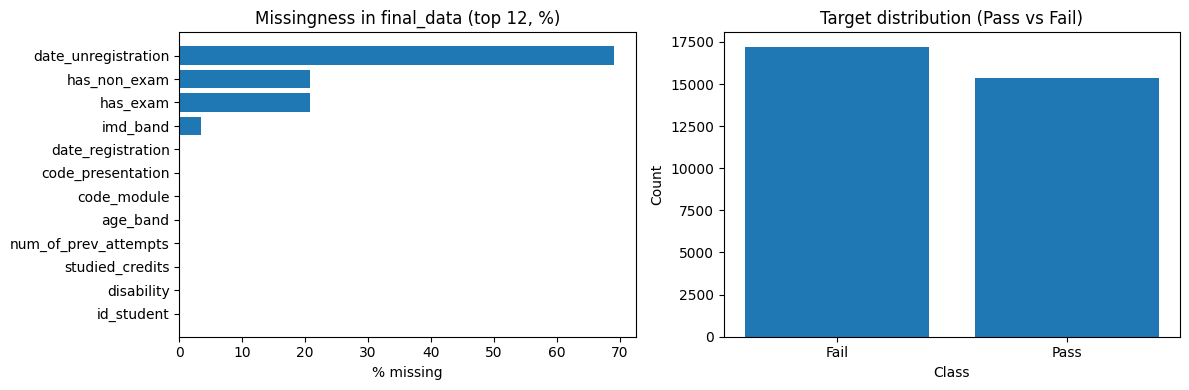

Target counts:
final_result_upd
Fail    17208
Pass    15385
Name: count, dtype: int64
Target %:
final_result_upd
Fail    52.8
Pass    47.2
Name: count, dtype: float64
Imbalance ratio (majority/minority): 1.12x


In [10]:
# --- 5.1 Data overview + missingness + target balance
import math

overview = pd.DataFrame({
    'table': ['assessments','courses','studentInfo','studentRegistration','studentAssessment','vle','studentVle'],
    'rows': [len(assessments),len(courses),len(student_info),len(student_reg),len(student_assess),len(vle),len(student_vle)],
    'cols': [assessments.shape[1],courses.shape[1],student_info.shape[1],student_reg.shape[1],student_assess.shape[1],vle.shape[1],student_vle.shape[1]]
})
print(overview)

miss = (final_data.isna().mean() * 100).sort_values(ascending=False).head(12)
counts = final_data['final_result_upd'].value_counts()
perc = counts / counts.sum() * 100
imbalance = counts.max() / counts.min()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].barh(miss.index.astype(str), miss.values)
axes[0].set_title('Missingness in final_data (top 12, %)')
axes[0].invert_yaxis()
axes[0].set_xlabel('% missing')

axes[1].bar(counts.index, counts.values)
axes[1].set_title('Target distribution (Pass vs Fail)')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class')

plt.tight_layout()
plt.show()

print('Target counts:')
print(counts)
print('Target %:')
print(perc.round(2))
print(f'Imbalance ratio (majority/minority): {imbalance:.2f}x')


Section 5.2 Distributions and class separation. Histograms and boxplots are shown in one block for key numeric features.


/tmp/ipykernel_33484/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
/tmp/ipykernel_33484/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
/tmp/ipykernel_33484/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
/tmp/ipykernel_33484/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' 

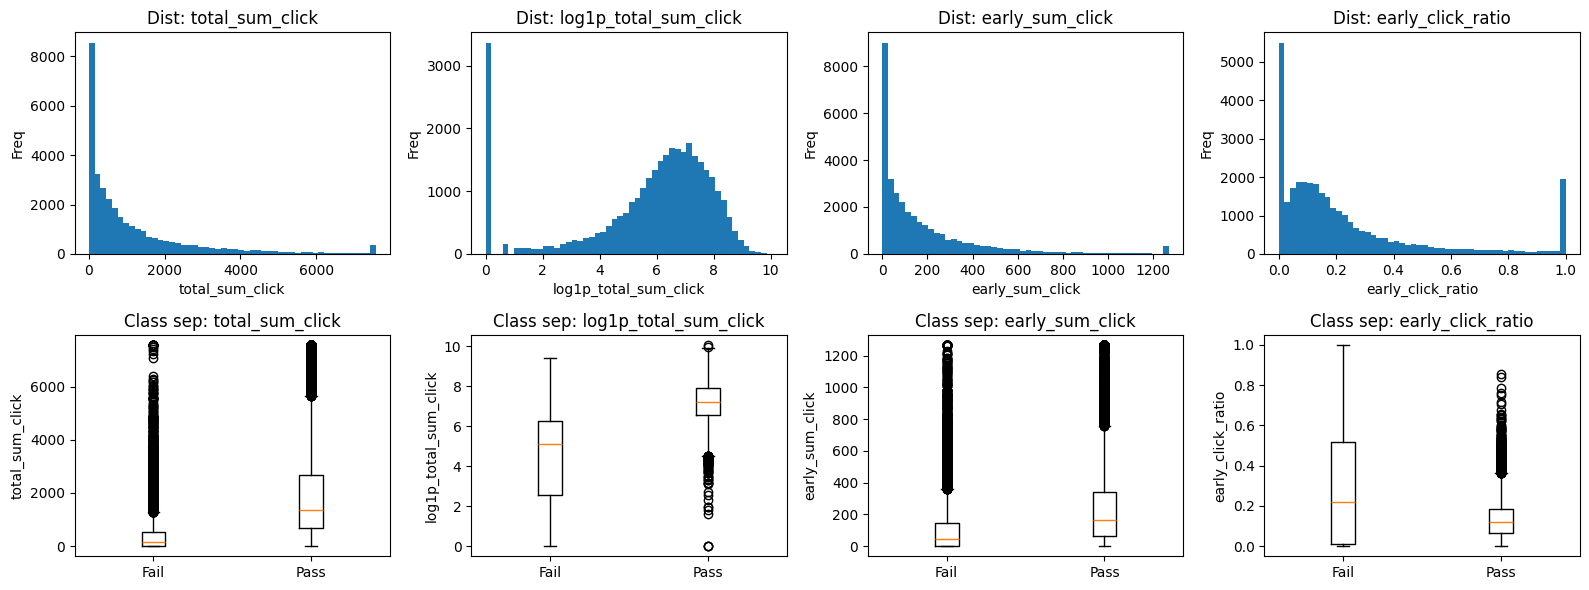

In [11]:
# --- 5.2 Distributions + class separation (single block)
key_num = [
    'total_sum_click','log1p_total_sum_click','early_sum_click','early_click_ratio',
    'active_days','overall_grade','mean_score','late_submissions'
]
cols = [c for c in key_num if c in final_data.columns]

ncols = 4
nrows = 2  # top row: hist, bottom row: boxplot
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 6))

for i, col in enumerate(cols[:ncols]):
    ax = axes[0, i]
    ax.hist(final_data[col].dropna(), bins=50)
    ax.set_title(f'Dist: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Freq')

    ax2 = axes[1, i]
    pass_vals = final_data.loc[final_data['final_result_upd_numeric']==1, col]
    fail_vals = final_data.loc[final_data['final_result_upd_numeric']==0, col]
    ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
    ax2.set_title(f'Class sep: {col}')
    ax2.set_ylabel(col)

# hide unused axes if fewer than 4 features
for j in range(len(cols[:ncols]), ncols):
    axes[0, j].axis('off')
    axes[1, j].axis('off')

plt.tight_layout()
plt.show()


Section 5.3 Pass rates by key demographic factors.


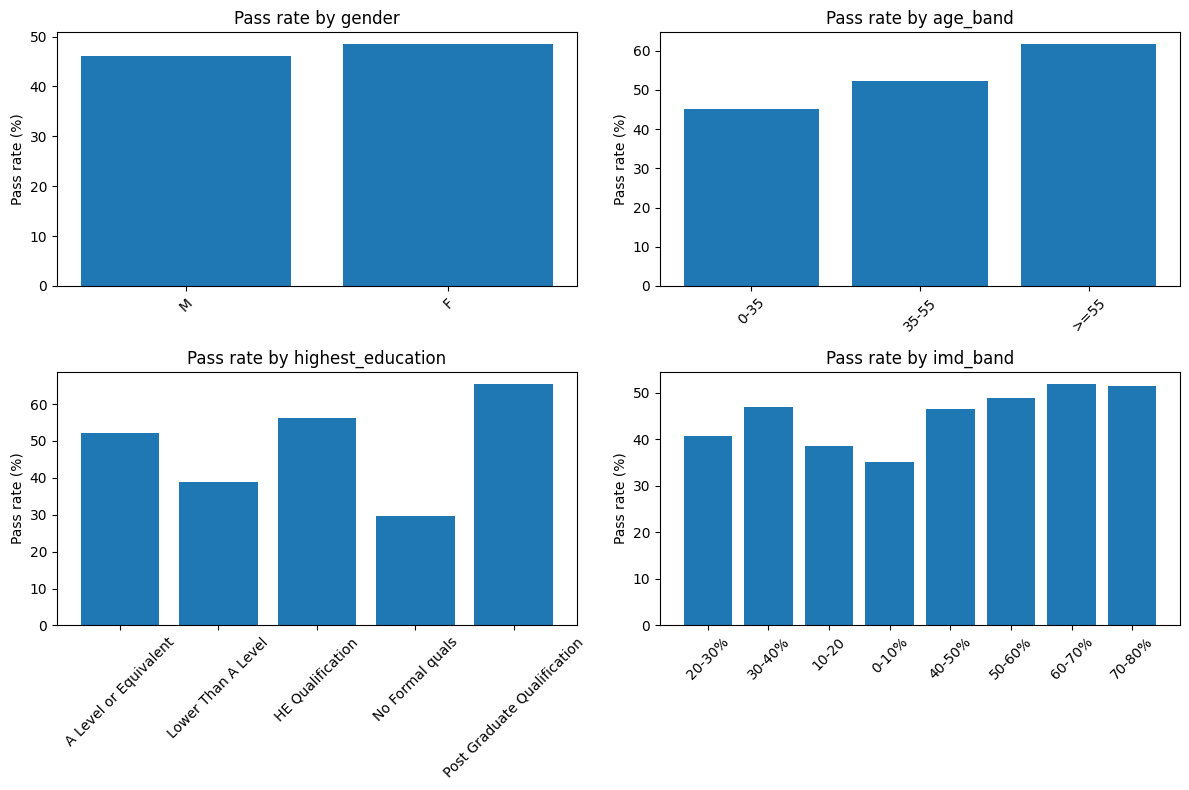

In [12]:
# --- 5.3 Pass rates by demographics (key factors)
cat_cols = ['gender','age_band','highest_education','imd_band']

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    if col not in final_data.columns:
        ax.axis('off')
        continue

    grp = (
        final_data.groupby(col)['final_result_upd_numeric']
        .agg(['mean','count'])
        .sort_values('count', ascending=False)
        .head(8)
    )
    ax.bar(grp.index.astype(str), grp['mean'] * 100)
    ax.set_title(f'Pass rate by {col}')
    ax.set_ylabel('Pass rate (%)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Section 5.4 Pass rates by module.


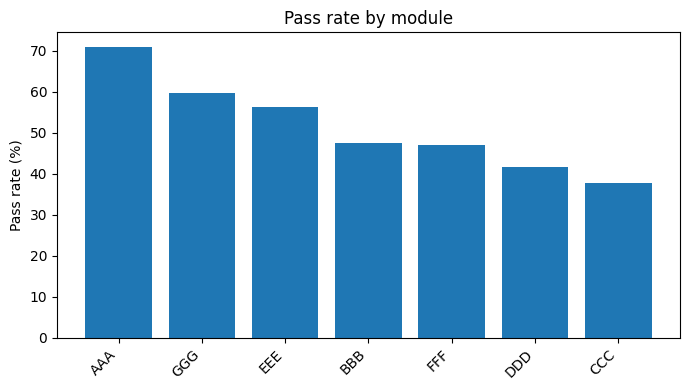

In [13]:
# --- 5.4 Pass rates by module
if 'code_module' in final_data.columns:
    module_rates = (
        final_data.groupby('code_module')['final_result_upd_numeric']
        .agg(['mean','count'])
        .sort_values('mean', ascending=False)
    )

    plt.figure(figsize=(7,4))
    plt.bar(module_rates.index.astype(str), module_rates['mean'] * 100)
    plt.title('Pass rate by module')
    plt.ylabel('Pass rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Section 5.5 Correlations with the target for numeric features.


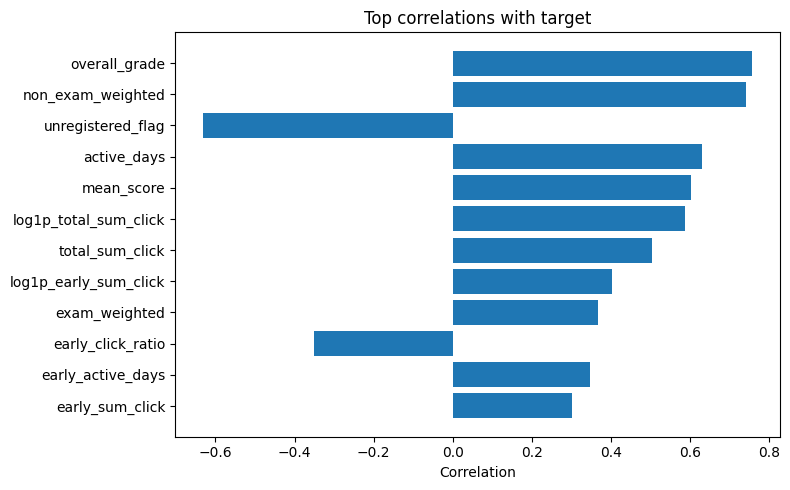

In [14]:
# --- 5.5 Correlations with target (numeric features)
num_cols = final_data.select_dtypes(include=['number']).columns.tolist()
if 'final_result_upd_numeric' in num_cols:
    corrs = (
        final_data[num_cols]
        .corr()['final_result_upd_numeric']
        .drop('final_result_upd_numeric')
        .sort_values(key=lambda s: s.abs(), ascending=False)
    )
    top_corrs = corrs.head(12)

    plt.figure(figsize=(8,5))
    plt.barh(top_corrs.index.astype(str), top_corrs.values)
    plt.title('Top correlations with target')
    plt.xlabel('Correlation')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    top_corrs


Section 6 Modeling baseline. A single pipeline performs imputation, scaling, one hot encoding, and logistic regression.


Section 6.1 Algorithm principles. Logistic regression is interpretable, decision trees capture non linear patterns, and random forest reduces variance by ensembling trees.


In [15]:
# Define X, y
TARGET = 'final_result_upd_numeric'
DROP_COLS = ['final_result', 'final_result_upd', TARGET]

X = final_data.drop(columns=[c for c in DROP_COLS if c in final_data.columns])
y = final_data[TARGET].astype(int)

# Prediction goal controls potential leakage features
PREDICTION_GOAL = 'early_warning'  # options: 'end_of_course', 'early_warning'
LEAKAGE_FEATURES = [
    'overall_grade','exam_weighted','non_exam_weighted','mean_score','late_submissions'
]

if PREDICTION_GOAL == 'early_warning':
    drop_cols = [c for c in LEAKAGE_FEATURES if c in X.columns]
    X = X.drop(columns=drop_cols)
    print('Early-warning mode: dropping assessment-derived features:', drop_cols)
else:
    print('End-of-course mode: using full feature set (including assessment-derived features).')

# Split (stratified for fair class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Column types
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OneHotEncoder compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

baseline_clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)

baseline_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', baseline_clf)
])

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

print('Baseline metrics')
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall   :', recall_score(y_test, y_pred))
print('F1       :', f1_score(y_test, y_pred))


Early-warning mode: dropping assessment-derived features: ['overall_grade', 'exam_weighted', 'non_exam_weighted', 'mean_score', 'late_submissions']


Baseline metrics
Accuracy : 0.9153244362632306
Precision: 0.869260017548991
Recall   : 0.9658758531036724
F1       : 0.9150246305418719


Section 7 Feature selection and leakage analysis. Early warning mode avoids assessment derived features because they can leak the final result.


Section 7.0 Leakage analysis. Assessment scores come from the same grading process that defines the outcome, so they are used only for end of course analysis.


In [16]:
# --- 7.0 Assessment timing + leakage check
assess_stats = (
    assessments.groupby('assessment_type')
    .agg(
        count=('id_assessment','count'),
        median_weight=('weight','median'),
        median_date=('date','median')
    )
    .sort_values('count', ascending=False)
)
assess_stats

# Exam timing relative to course length
assess_len = assessments.merge(courses, on=['code_module','code_presentation'], how='left')
exam = assess_len[assess_len['assessment_type'] == 'Exam'].copy()
if len(exam):
    exam['date_pct'] = exam['date'] / exam['module_presentation_length']
    print('Median exam date as % of course length:', round(exam['date_pct'].median()*100, 1), '%')

# Strength of correlation for assessment-derived features
for col in ['overall_grade','exam_weighted','non_exam_weighted','mean_score','late_submissions']:
    if col in final_data.columns:
        corr = final_data[[col,'final_result_upd_numeric']].corr().iloc[0,1]
        print(f'Correlation with target: {col} -> {corr:.3f}')


Median exam date as % of course length: 92.1 %
Correlation with target: overall_grade -> 0.757
Correlation with target: exam_weighted -> 0.368
Correlation with target: non_exam_weighted -> 0.740
Correlation with target: mean_score -> 0.602
Correlation with target: late_submissions -> 0.286


Section 7.1 RFECV selection curve. Cross validation selects the number of features that yields the best F1 score.


Optimal number of features: 61
Selected features:
 - id_student
 - num_of_prev_attempts
 - studied_credits
 - total_sum_click
 - active_days
 - early_sum_click
 - early_active_days
 - early_click_ratio
 - log1p_total_sum_click
 - log1p_early_sum_click
 - has_exam
 - has_non_exam
 - date_registration
 - date_unregistration
 - unregistered_flag
 - code_module_AAA
 - code_module_BBB
 - code_module_CCC
 - code_module_DDD
 - code_module_EEE
 - code_module_FFF
 - code_module_GGG
 - code_presentation_2013B
 - code_presentation_2013J
 - code_presentation_2014B
 - code_presentation_2014J
 - gender_F
 - gender_M
 - region_East Anglian Region
 - region_East Midlands Region
 - region_Ireland
 - region_London Region
 - region_North Region
 - region_North Western Region
 - region_Scotland
 - region_South East Region
 - region_South Region
 - region_South West Region
 - region_Wales
 - region_West Midlands Region
 - region_Yorkshire Region
 - highest_education_A Level or Equivalent
 - highest_educati

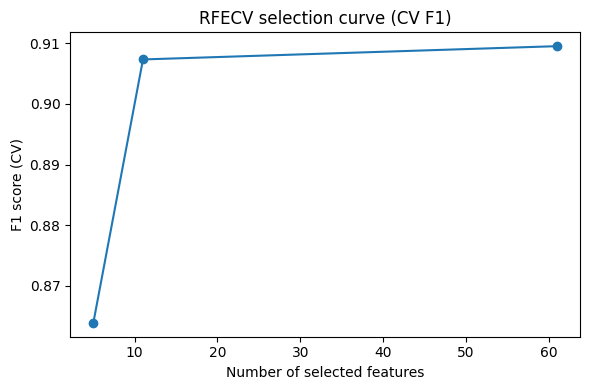


RFECV-selected model metrics
Accuracy : 0.9153244362632306
Precision: 0.869260017548991
Recall   : 0.9658758531036724
F1       : 0.9150246305418719


In [17]:
# --- 7.1 RFECV selection curve (cross-validated)
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

preprocess_fs = clone(preprocess)
X_train_t = preprocess_fs.fit_transform(X_train)
X_test_t = preprocess_fs.transform(X_test)

# Feature names after preprocessing
ohe = preprocess_fs.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
feature_names = np.array(num_cols + list(cat_names))

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    step=50,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    min_features_to_select=5
)

rfecv.fit(X_train_t, y_train)

selected_mask = rfecv.support_
selected_features = feature_names[selected_mask]

print('Optimal number of features:', rfecv.n_features_)
print('Selected features:')
for f in selected_features:
    print(' -', f)

# Plot selection curve
if hasattr(rfecv, 'cv_results_'):
    n_features = rfecv.cv_results_['n_features']
    scores = rfecv.cv_results_['mean_test_score']
else:
    n_features = range(1, len(rfecv.grid_scores_) + 1)
    scores = rfecv.grid_scores_

plt.figure(figsize=(6,4))
plt.plot(n_features, scores, marker='o')
plt.title('RFECV selection curve (CV F1)')
plt.xlabel('Number of selected features')
plt.ylabel('F1 score (CV)')
plt.tight_layout()
plt.show()

# Train LR on selected features
clf_fs = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
clf_fs.fit(X_train_t[:, selected_mask], y_train)

y_pred_fs = clf_fs.predict(X_test_t[:, selected_mask])

print('')
print('RFECV-selected model metrics')
print('Accuracy :', accuracy_score(y_test, y_pred_fs))
print('Precision:', precision_score(y_test, y_pred_fs))
print('Recall   :', recall_score(y_test, y_pred_fs))
print('F1       :', f1_score(y_test, y_pred_fs))


In [18]:
# --- 7.3 Top features (importance proxy via |coef| for LR)
coefs = clf_fs.coef_.ravel()
coef_df = pd.DataFrame({'feature': selected_features, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).drop(columns='abs_coef')

coef_df


,feature,coef
17,code_module_CCC,-3.941224
18,code_module_DDD,-3.716987
14,unregistered_flag,-3.246119
16,code_module_BBB,2.220803
8,log1p_total_sum_click,2.124957
...,...,...
25,code_presentation_2014J,-0.039076
39,region_West Midlands Region,-0.035882
12,date_registration,-0.032393
2,studied_credits,-0.013070


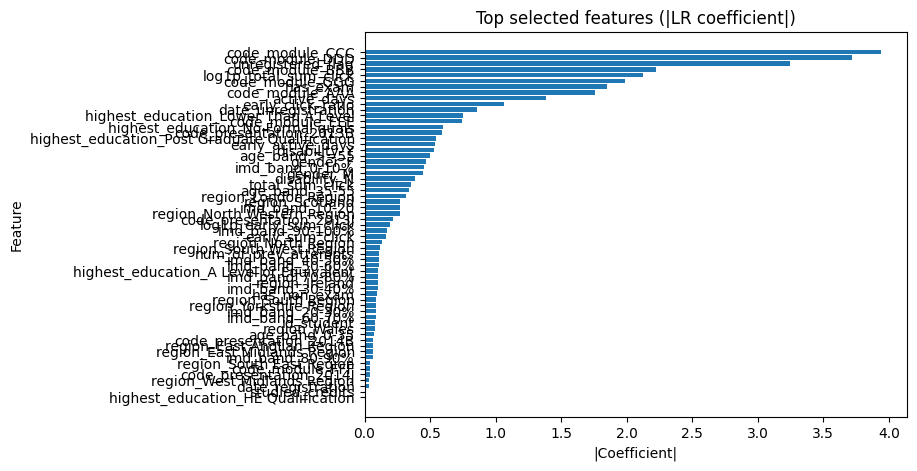

In [19]:
# Plot top features by |coef|
plot_df = coef_df.copy()
plot_df['abs_coef'] = plot_df['coef'].abs()
plot_df = plot_df.sort_values('abs_coef', ascending=True)

plt.figure(figsize=(7, 5))
plt.barh(plot_df['feature'], plot_df['abs_coef'])
plt.title('Top selected features (|LR coefficient|)')
plt.xlabel('|Coefficient|')
plt.ylabel('Feature')
plt.show()


In [20]:
# --- 7.5 Direction of top coefficients (LR)
coef_dir = coef_df.sort_values('coef', ascending=False)
print('Top positive coefficients (increase Pass odds):')
print(coef_dir.head(10))
print('')
print('Top negative coefficients (decrease Pass odds):')
print(coef_dir.tail(10))


Top positive coefficients (increase Pass odds):
                                          feature      coef
16                                code_module_BBB  2.220803
8                           log1p_total_sum_click  2.124957
21                                code_module_GGG  1.984144
10                                       has_exam  1.848456
15                                code_module_AAA  1.756457
4                                     active_days  1.387685
19                                code_module_EEE  0.742712
45  highest_education_Post Graduate Qualification  0.543525
9                           log1p_early_sum_click  0.191648
55                               imd_band_90-100%  0.170051

Top negative coefficients (decrease Pass odds):
                                 feature      coef
60                          disability_Y -0.527736
6                      early_active_days -0.539223
22               code_presentation_2013B -0.590429
44     highest_education_No Formal qual

Section 8 Evaluation. We report accuracy, precision, recall, F1, classification report, and confusion matrix.


Classification report (RFE-selected LR):
              precision    recall  f1-score   support

        Fail       0.97      0.87      0.92      3442
        Pass       0.87      0.97      0.92      3077

    accuracy                           0.92      6519
   macro avg       0.92      0.92      0.92      6519
weighted avg       0.92      0.92      0.92      6519



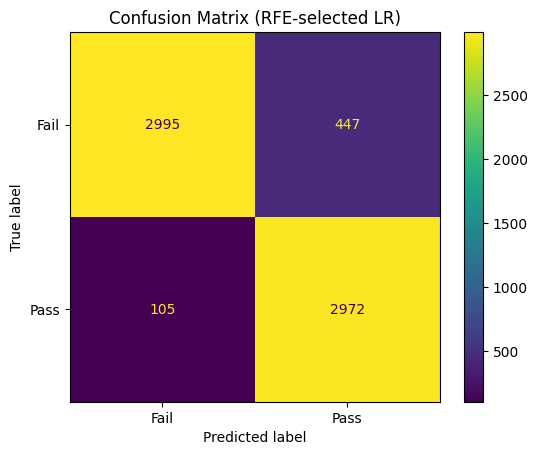

In [21]:
print('Classification report (RFE-selected LR):')
print(classification_report(y_test, y_pred_fs, target_names=['Fail','Pass']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fs, display_labels=['Fail','Pass'])
plt.title('Confusion Matrix (RFE-selected LR)')
plt.show()


Section 8.1 Interpretation and recommendations. Early engagement and consistent activity are key signals for early warning. Use outreach and support for low engagement.


Section 9 Bonus comparison of multiple algorithms.


In [22]:
models = {
    'LogReg (balanced)': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
}

rows = []
for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1': f1_score(y_test, pred)
    })

bonus_results = pd.DataFrame(rows).sort_values('F1', ascending=False)
bonus_results


,Model,Accuracy,Precision,Recall,F1
0,LogReg (balanced),0.915324,0.869260,0.965876,0.915025
2,Random Forest,0.912103,0.867587,0.960351,0.911615
1,Decision Tree,0.892928,0.831799,0.969126,0.895227


Section 10 Conclusions and next steps. The dataset is large and supports real world analysis. Future work can add time window features and threshold tuning.
